In [2]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LaTeXStrings
using Printf
using LsqFit

In [3]:
include("aux_functions.jl")

retrieve_meta_data (generic function with 1 method)

In [25]:
outputs = false # detailed output (no longer used)
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote as a script avoid all plots 
save_plots = true # put true is you want so save your plots.
plots = true

true

#### Primero hacemos el caso undamped

In [56]:
data, run_name, par_grid, par_evolv, par_f, n0, x, t_series = retrieve_meta_data("Results/landau_undamped_rel_t400_L39.738_N8_5_J3522_M16001_o5_T3.jld2")
@show run_name
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f


run_name = "ltd_landau_vla40_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3"
(N, L, J, dx, order) = par_grid = (800000, 40, 400, 0.1, 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 100.0, 2001, 2001, 0.05)
(θ, nm, κ) = par_f = (0.001, 2, 0.15707963267948966)


(0.001, 2, 0.15707963267948966)

In [57]:
v = retrieve_data(data, par_grid, par_evolv);

In [ ]:
exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = t_i
e = 1
m = 1

In [60]:
if !remote_server || plots
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:50:M_g
        plt = plot!(x,1e0*v[2N+1:end,j].+ofset*j)
    end
    plt
    if save_plots
    png("Images/" * run_name * "_electric_field")
    end
end

In [63]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)

j = M_g

p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, par_grid)
get_ϕ!(ϕ_f, ρ_f .+ 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if !remote_server || plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final"
    )
    if save_plots
    png("Images/" * run_name * "_Efield")
    end
end


In [ ]:
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T = get_averages(v,par_grid,par_evolv, par_f);

In [ ]:
if plots || !remote_server
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N .- 1, label="charge")
    plot!(subplot=4, S_T, label="Total Current")
    if save_plots
        png("Images/"  * run_name * "_total_run")
    end
end

In [ ]:
if plots || !remote_server
plot(layout=(2,2), title="order = $(order)")
plot!(subplot=1,t_series,EField_T,title="Total Electric Field (order = $(order))")
plot!(subplot=2,t_series,p_T./N, title="Total velocity (order = $(order))")
plot!(subplot=3,t_series,Q_T,title = "Total density (order = $(order))")
plot!(subplot=4,t_series,S_T,title = "Total Current (order = $(order))")
    if save_plots   
        png("Images/"  * run_name * "_totals")
    end
end


In [ ]:
if plots || !remote_server
    plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
    #, legend = :outertopright
    , legend = :bottomright, ls=:dash)
    plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
    plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
    , yscale=:log10
    #, xscale=:log10
    , label = "Total Energy / Initial Energy -1 ")
    if save_plots
    png("Images/" * run_name * "energy_conservation")
    end
end

#### Now we look for the temperature variation

In [ ]:
T = [var(v[N+1:2N,j]) for j in 1:M_g]

plot(t_series,T, label= "θ", title = "Temperature = var", legend = false)
png("Images/" * run_name * "_temperature")

In [ ]:
p0 = [0.001, 0.005, 1.0, -π/2, 0.000, 0.0, 0.0, 0.0]
p1 = [0.001, 0.005, 2.0, -π/2, 0.000, 2.0, 0.0, 0.002]
@. model_0(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]))^2 #*cos(x*p[5] + p[6])
@. model_1(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]) + p[5]*cos(x*p[6] + p[7]))*exp(-p[8]*x) #*cos(x*p[5] + p[6])

In [ ]:
fit_0 = curve_fit(model_0, t_series, T, p0);
@show fit_0.param
fit_1 = curve_fit(model_1, t_series, T, p1);
@show fit_1.param


In [ ]:
if plots || !remote_server
    Plots.scatter(t_series, T, label= "θ", title = "Temperature = var", legend = false, xlim=(300,400), ms=2)
    #plot!(t_series, model_0(t_series, fit_0.param), markersize = 1, lable="simple fit")
    plot!(t_series, model_1(t_series, fit_1.param), markersize = 1)
    #png("Images/" * run_name * "temperature_fit")
    if save_plots
        png("Images/" * run_name * "temperature_fit_closeup")
    end
end

In [ ]:
cov = estimate_covar(fit_1)

#sqrt(Diagonal(cov))

#margin_of_error = margin_error(fit, 0.1)


#confidence_intervals = confidence_interval(fit, 0.1)

For these parámeters the fit is:

`[1.0009490930490625
 67.82701283760936
  1.0002810154957107
  0.00019119530305159043]`


The cov matrix is:
 
 `2.20767e-15  -2.94447e-15   7.41979e-17  -1.00864e-14
 -2.94447e-15   5.90124e-15   4.20125e-17  -1.29548e-14
  7.41979e-17   4.20125e-17   8.49937e-13  -8.49403e-11
 -1.00864e-14  -1.29548e-14  -8.49403e-11   1.13183e-8`

In [ ]:
Tft = T .- sum(T)/length(T)
#Th = rfft(Ttf.*exp.(0.0020769924816417553.* t_series))
Th = rfft(Tft)

if plots || !remote_server
    plot(layout=(2,1), title="Fourier Transform of Temperature")
    Plots.scatter(subplot=1,real.(Th)
        #,xlim=(0,200)
        #,ylim=(-0.01,0.01)
        ,label=false
        )

    Plots.scatter(subplot=2,imag.(Th)
        ,xlim=(0,200)
        )
end

#### The Electric Energy

In [ ]:
if plots || !remote_server
    Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy decay"
    , label= "Electric Energy"
    , yscale=:log10
    )
end

In [ ]:
if plots || !remote
    plot(t_series[2:end],Energy_E[2:end] .- Energy_E[1], label = "|Electric Energy|", ls=:dot)
end

In [ ]:
@. model_e1(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
pe1 = [1.0; 1; 2; 2; 0.002]
pe2 = [1.0; 1; 1; 0; 0.002; 0.5]

fit_energy_1 = curve_fit(model_e1, t_series, Energy_E, pe1);
fit_energy_2 = curve_fit(model_e2, t_series, Energy_E, pe2);
@show fit_energy_1.param
@show fit_energy_2.param

In [ ]:
if plots || !remote_server
    Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy oscillations"
    , label= "Electric Energy"
    #, yscale=:log10
    )

    plot!(t_series,model_e1(t_series,fit_energy_1.param)
    , markersize = 0.2
    #, xlims=(00,400)
    , label="Fit"
    )
    plot!(t_series,model_e2(t_series,fit_energy_2.param), ls=:dash
    , markersize = 0.2
    , xlims=(300,400)
    , label="Fit"
    )
    if save_plots
        png("Images/" * run_name * "_energy_fit")
    end
end


### Ahora chequeamos con damping ###

In [ ]:

file_name = "Results/landau_damped_rel_t40_L7.455_N8_5_J930_M1601_o5_T3.jld2"
#file_name = "Results/landau_damped_rel_t400_L7.455_N8_5_J930_M16001_o5_T3.jld2"



data = load(file_name);
run_name = data["run_name"]
par_grid = data["par_grid"]
par_evolv = data["par_evolv"]
par_f = data["p_Ini"]
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f

x = [(i-1)*dx for i in 1:J]

dT = dt * (M-1) / (M_g-1)

t_series = [(i-1)*dT for i in 1:M_g]

#M_g = 501 



In [ ]:



v = zeros(2N+J,M_g)

for j in 1:M_g
    tiempo = @sprintf("%05d", j)
    v[:,j] = data["u/u_$tiempo"]
end

#run = Dict("p"=>p, "Energy_E"=>Energy_E, "Energy_K"=>Energy_K, "E_f"=>E_f, "n_F"=>n_F,  "S_F"=>S_F, "E_T"=>E_T, "v_T"=>v_T, "S_T"=>S_T, "D_T"=>D_T, "T"=>T)

#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T)
#p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_damped_t200_L7.455_N8_4_J930_M2001_o5_T3th20_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");

#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_dumped_t100_L7.455_N2_5_J930_M1001_o5_T3th1_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");
#data_d  = load("Results/landau_damped_t400_L7.455_N8_4_J930_M16001_o5_T3th4_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");


In [ ]:
#(L, N, J, κ, dx, order) = data_d["p"]

exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = 0.0
e = 1
m = 1

animation = false
plots = true


In [ ]:
if plots || !remote_server
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:M_g
        plt = plot!(x,1e0*v[2N+1:end,j].+ofset*j)
    end
    plt
    if save_plots
        png("Images/" * run_name * _electric_field")
    end
end

In [ ]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)

j = M_g

p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, par_grid)
get_ϕ!(ϕ_f, ρ_f .+ 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final"
    )

    png("Efield_th$(nthreads())_" * run_name)
end


In [ ]:
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
Q_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
E_K = zeros(J)
P = zeros(J)
ρ = zeros(J)
S = zeros(J)

for j in 1:M_g
    (Energy_K[j],Energy_E[j]) = get_energy_rel(v[:,j],(L,N,J))
    EField_T[j] = sum(v[2N+1:end,j])*dx
    #p_T[j] = sum(get_momentum!(v[:,j],P,(Nx, dx, Np, dp)))*dx
    get_density!(v[:,j], ρ, par_grid)
    get_current_rel!(v[:,j], S, par_grid)
    Q_T[j] = get_total_charge(ρ,(J, dx))
    S_T[j] = sum(S)/N/Q_T[j]
end

In [ ]:
if plots || !remote_server
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N .- 1, label="charge")
    plot!(subplot=4, S_T, label="Total Current")
    if save_plots
        png("Images/"  * run_name * "_total_run")
    end
end

In [ ]:


plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright, ls=:dash)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
, yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png("Images/" * run_name * "energy_conservation")

In [ ]:
T = [var(v[N+1:2N,j]) for j in 1:M_g]

plot(t_series,T, label= "θ", title = "Temperature = var", legend = false)
#png("Images/" * run_name * "temperature")

In [ ]:
p0 = [0.001, 0.005, 1.0, -π/2, 0.000, 0.0, 0.0, 0.0]
p1 = [0.001, 0.005, 2.0, -π/2, 0.000, 2.0, 0.0, 0.002]
@. model_0(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]))^2 #*cos(x*p[5] + p[6])
@. model_1(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]) + p[5]*cos(x*p[6] + p[7]))*exp(-p[8]*x) #*cos(x*p[5] + p[6])

In [ ]:
fit_0 = curve_fit(model_0, t_series, T, p0);
fit_0.param

In [ ]:
fit_1 = curve_fit(model_1, t_series, T, p1);
fit_1.param

In [ ]:
if plots || !remote_server
    Plots.scatter(t_series, T, label= "θ", title = "Temperature = var", legend = false, xlim=(300,400), ms=2)
    #plot!(t_series, model_0(t_series, fit_0.param), markersize = 1, lable="simple fit")
    plot!(t_series, model_1(t_series, fit_1.param), markersize = 1)
    if save_plots
        png("Images/" * run_name * "temperature_fit_closeup")
    end
end


In [ ]:
cov = estimate_covar(fit)

In [ ]:
Tft = T .- sum(T)/length(T)
#Th = rfft(Ttf.*exp.(0.0020769924816417553.* t_series))
Th = rfft(Tft)
if plots || !remote_server
    plot(layout(2,1))
    Plots.scatter!(subplot=1, real.(Th)
    #,xlim=(0,200)
    #,ylim=(-0.01,0.01)
    ,label=false
    )
    Plots.scatter!(subplot=2, imag.(Th)
    ,xlim=(0,200)
    )
end

#### The Electric Energy

In [ ]:
@. model_e1(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
pe1 = [1.0; 1; 2; 2; 0.002]
pe2 = [1.0; 1; 1; 0; 0.002; 0.5]

fit_energy_1 = curve_fit(model_e1, t_series, Energy_E, pe1);
fit_energy_2 = curve_fit(model_e2, t_series, Energy_E, pe2);
fit_energy_1.param
fit_energy_2.param

In [ ]:
if plots || !remote_server 
    Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy decay"
    , label= "Electric Energy"
    #, yscale=:log10
    )

    plot!(t_series,model_e1(t_series,fit_energy_1.param), ls=:dash
    , markersize = 0.2
    #, xlims=(00,400)
    , label="Fit"
    )
    plot!(t_series,model_e2(t_series,fit_energy_2.param), ls=:dash
    , markersize = 0.2
    , xlims=(300,400)
    , label="Fit"
    )
    if save_plots
        png("Images/" * run_name * "_energy_fit")
    end
end

La frecuencia parece estar en $\omega = 1.002757$

### Large perturbations



#### Run ltd_landau_try_rel_t4_L200_N8_5_J200_M801_o5_T3_alp1.jld2

In [ ]:
data, run_name, par_grid, par_evolv, par_f, n0, x, t_series = retrieve_meta_data("Results/ltd_landau_try_rel_t40_L200_N8_5_J200_M8001_o5_T3_alp1.jld2")
@show run_name
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f

In [ ]:
v = retrieve_data(data, par_grid, par_evolv);

In [ ]:
exp_Theta = 3 #this can be read from run_name
exp_t = 0 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = t_i
e = 1
m = 1

#animation = false
#plots = true

In [ ]:
if plots 
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:1:M_g
        plt = plot!(x,1e0*v[2N+1:end,j].+ofset*j)
    end
    plt
    if save_plots
    png("Images/" * run_name * "_electric_field")
    end
end
plt

In [ ]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)
j = M_g

p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, par_grid)
get_ϕ!(ϕ_f, ρ_f .+ 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plt = plot(x,E_f,label="E_f from density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final")
    if save_plots
        png("Images/" * run_name * "_Efield")
    end
end
plt


In [ ]:
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T = get_averages(v,par_grid,par_evolv, par_f);

In [ ]:
if plots 
    factor = 200
    plt = plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N .- 1, label="charge")
    plot!(subplot=4, S_T, label="Total Current", legend=:topleft)
    if save_plots
        png("Images/"  * run_name * "_total_run")
    end
end
plt

In [ ]:
if plots || !remote_server
    plt = plot(layout=(2,2), title="order = $(order)")
    plot!(subplot=1,t_series,EField_T,title="Total Electric Field (order = $(order))")
    plot!(subplot=2,t_series,p_T./N, title="Total velocity (order = $(order))")
    plot!(subplot=3,t_series,Q_T,title = "Total density (order = $(order))")
    plot!(subplot=4,t_series,S_T,title = "Total Current (order = $(order))")
    if save_plots
        png("Images/"  * run_name * "_totals")
    end
end
plt

In [ ]:
if plots || !remote_server
    plt = plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
    #, legend = :outertopright
    , legend = :bottomright, ls=:dash)
    plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
    plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
    , yscale=:log10
    #, xscale=:log10
    , label = "Total Energy / Initial Energy -1 ")
    if save_plots
        png("Images/" * run_name * "energy_conservation")
    end
end
plt

In [ ]:
if plots || !remote_server 
    T = [var(v[N+1:2N,j]) for j in 1:M_g]
    plt = plot(t_series,T, label= "θ", title = "Temperature = var", legend = false)
    if save_plots
        png("Images/" * run_name * "_temperature")
    end
end
plt

In [ ]:
Tft = T .- sum(T)/length(T)
#Th = rfft(Ttf.*exp.(0.0020769924816417553.* t_series))
Th = rfft(Tft)

if plots || !remote_server
    plot(layout=(1,2))
    Plots.scatter!(subplot=1,real.(Th)
    ,xlim=(0,20)
    #,ylim=(-0.01,0.01)
    ,label="real part"
    )
    Plots.scatter!(subplot=2,imag.(Th)
    ,xlim=(0,20)
    #,ylim=(-0.01,0.01)
    ,label="imaginary part"
    )
end

In [ ]:
@. model_tl(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
p_tl = [0.8; -0.8; 2; 0; 0.1; 0; 1.; 0; 0]
fit_tl = curve_fit(model_tl, t_series[1:500], T[1:500], p_tl)

In [ ]:
Plots.scatter(t_series, T, ms = 1)
plot!(t_series, model_tl(t_series,fit_tl.param))

In [ ]:
length(T)

In [ ]:
v_max = maximum(v[N+1:2N,:])
dT = (t_f - t_i)/(M_g-1)
if true
    anim = @animate for j = 1:M_g
        Plots.scatter(v[1:N,j], v[N+1:2N,j]
        , markersize = 0.3
        , title = "phase-space " *  @sprintf("%04.2f", dT*(j-1))
        , legend=false
        , ylim = (-v_max*1.1,v_max*1.1)
        , xlim = (0,L)
        )
    end
 
    gif(anim, "Images/" * run_name * "ps_fps5.gif", fps = 5)
end

### Small Perturbations Tests



#### Run ltd_landau_try_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3.jld2

In [5]:
data, run_name, par_grid, par_evolv, par_f, n0, x, t_series = retrieve_meta_data("Results/ltd_landau_vla40_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3.jld2")
@show run_name
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f
#run_name = "ltd_landau_try_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3.jld2"

run_name = "ltd_landau_vla40_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3"
(N, L, J, dx, order) = par_grid = (800000, 40, 400, 0.1, 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 100.0, 2001, 2001, 0.05)
(θ, nm, κ) = par_f = (0.001, 2, 0.15707963267948966)


(0.001, 2, 0.15707963267948966)

In [6]:
v = retrieve_data(data, par_grid, par_evolv);

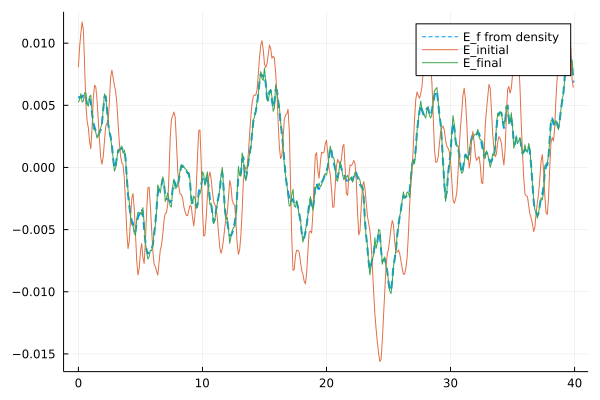

In [26]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)
j = M_g


#p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, par_grid)
get_ϕ!(ϕ_f, ρ_f .- 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plt = plot(x,E_f,label="E_f from density", ls=:dash, lw=2)
    plt = plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final")
    if save_plots
        png("Images/" * run_name * "_Efield")
    end
end
plt

In [8]:
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages(v,par_grid,par_evolv, par_f);

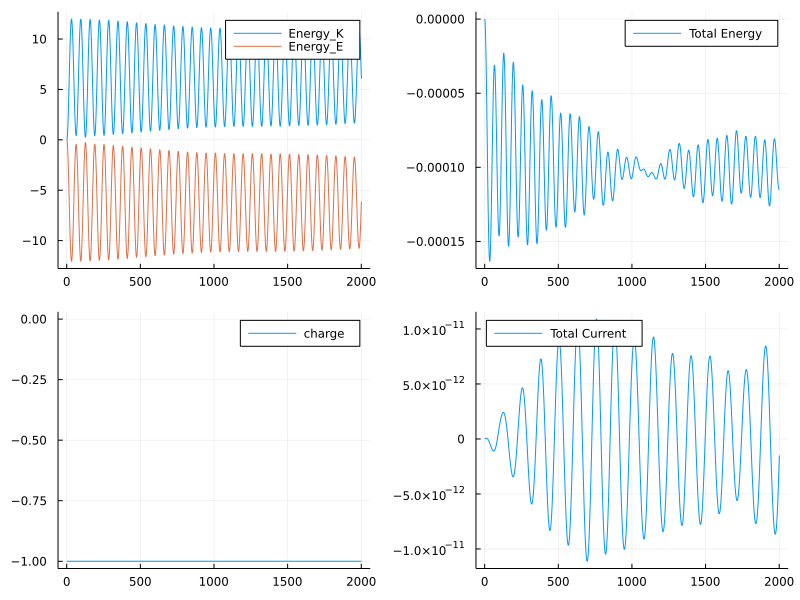

In [27]:
if plots 
    factor = 200
    plt = plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N .- 1, label="charge")
    plot!(subplot=4, S_T, label="Total Current", legend=:topleft)
    if save_plots
        png("Images/"  * run_name * "_total_run")
    end
end
plt

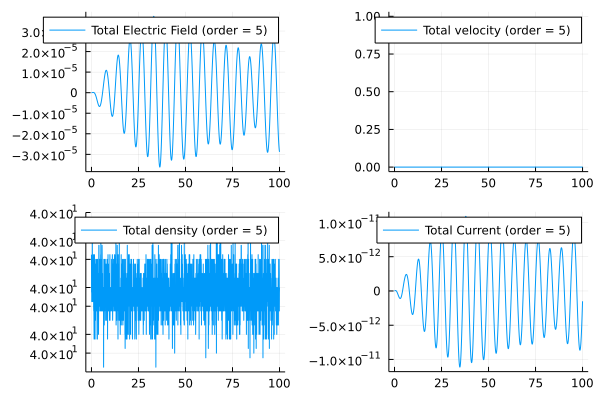

In [28]:
if plots || !remote_server
    plt = plot(layout=(2,2)) #, title="order = $(order)")
    plot!(subplot=1,t_series,EField_T,label="Total Electric Field (order = $(order))")
    plot!(subplot=2,t_series,p_T./N, label="Total velocity (order = $(order))")
    plot!(subplot=3,t_series,Q_T,label = "Total density (order = $(order))")
    plot!(subplot=4,t_series,S_T,label = "Total Current (order = $(order))")
    if save_plots
        png("Images/"  * run_name * "_totals")
    end
end
plt

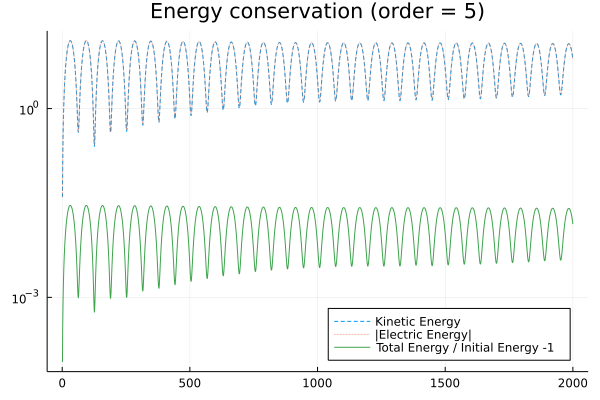

In [29]:
if plots || !remote_server
    plt = plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
    #, legend = :outertopright
    , legend = :bottomright, ls=:dash)
    plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
    plot!(abs.(2*Energy_K[2:end]  + Energy_E[2:end] .- (2*Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
    , yscale=:log10
    #, xscale=:log10
    , label = "Total Energy / Initial Energy -1 ")
    if save_plots
        png("Images/" * run_name * "energy_conservation")
    end
end
plt

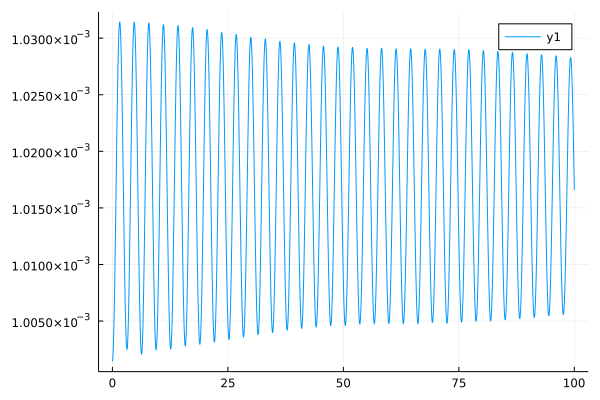

In [30]:
plot(t_series,T)

In [22]:
@. model_tl001(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
p_tl001 = [0.001; 3; 2; 0; 0.1; 0; 1.; 0; 0]
fit_tl001 = curve_fit(model_tl001, t_series[1:end], T[1:end], p_tl001)
@. model_tl001_s(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
p_tl001_s = [0.001; 3; 2; 0; 0.0]
fit_tl001_s = curve_fit(model_tl001_s, t_series[1:end], T[1:end], p_tl001_s)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.0010169145793037712, -1.4471995558024292e-5, 1.9957563551314361, -0.06704844805009498, 0.002614952416680316], [1.0437110225440614e-6, 9.229560707780908e-7, 8.002295139634095e-7, 6.766734634581963e-7, 5.534192170700541e-7, 4.315767459571549e-7, 3.122244959809749e-7, 1.963995978362075e-7, 8.508857560511271e-8, -2.078136212483976e-8  …  -7.543330998683803e-8, -5.2398350949833805e-8, -2.915788187523964e-8, -5.963457091421459e-9, 1.6933036015671574e-8, 3.928206457055709e-8, 6.083911971194352e-8, 8.136733973293335e-8, 1.0064005892302004e-7, 1.18443255123701e-7], [0.9999999999999915 0.9977530947421084 … -9.69597989229914e-7 0.0; 0.9999999999999915 0.9993334456920246 … 4.736574287046091e-7 7.231174574654276e-7; … ; 0.9999999999999915 -0.06332579047479141 … -1.1105690625127336e-5 -9.15992389163031e-5; 0.9999999999999915 0.013436807217967889 … -1.1140285663047755e-5 1.944574261487226e-5], true, Float64[])

In [31]:
N_i =1
N_f = M_g
Plots.scatter(t_series[N_i:N_f], T[N_i:N_f], ms = 1)
plot!(t_series[N_i:N_f], model_tl001_s(t_series[N_i:N_f],fit_tl001_s.param))
if save_plots
    png("Images/" * run_name * "temperature_fit")
end

In [14]:
fit_tl001_s.param

5-element Vector{Float64}:
  0.0010169145793037712
 -1.4471995558024292e-5
  1.9957563551314361
 -0.06704844805009498
  0.002614952416680316

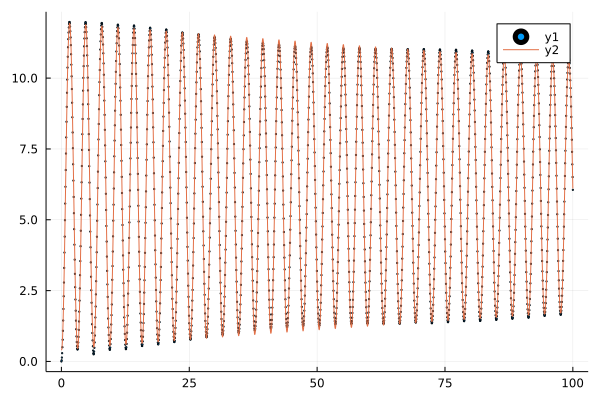

In [48]:
save_plots = true
@. energy_fit(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)

p0_e = [5.0;5.0;2.0;0.0;0.0]
fit_e = curve_fit(energy_fit, t_series[2:end], abs.(Energy_K[2:end] .- Energy_K[1]), p0_e)

plt = Plots.scatter(t_series[N_i:N_f], abs.(Energy_K[N_i:N_f] .- Energy_K[1]), ms = 1)
plot!(t_series[N_i:N_f], energy_fit(t_series[N_i:N_f],fit_e.param))
if save_plots
    png("Images/" * run_name * "energy_fit")
end
plt

In [47]:
fit_e.param

5-element Vector{Float64}:
  6.183062965886603
 -5.778044295565694
  1.9957567296053738
  6.216118491327009
  0.002609670014932032

In [49]:
@. model_e1(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
pe1 = [1.0; 1; 2; 2; 0.002]
pe2 = [1.0; 1; 1; 0; 0.002; 0.5]

fit_energy_1 = curve_fit(model_e1, t_series, Energy_E, pe1);
fit_energy_2 = curve_fit(model_e2, t_series, Energy_E, pe2);
fit_energy_1.param
fit_energy_2.param

6-element Vector{Float64}:
  5.77359125825347
 11.595357972411886
  0.9978835070958834
 -0.0343811006783687
  0.002649233461321959
  0.48170198460380087

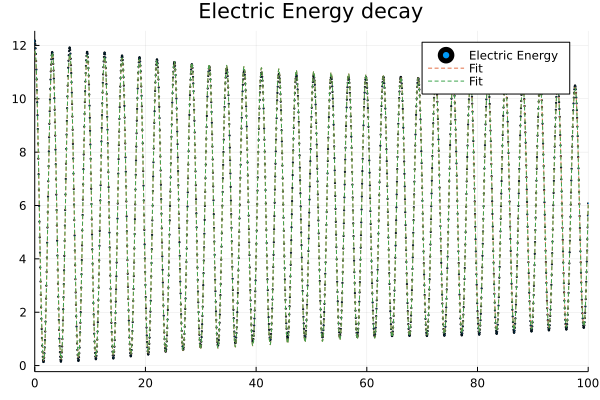

In [57]:
save_plots = true
if plots || !remote_server 
    plt = Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy decay"
    , label= "Electric Energy"
    #, yscale=:log10
    )

    plot!(t_series,model_e1(t_series,fit_energy_1.param), ls=:dash
    , markersize = 0.2
    #, xlims=(00,100)
    , label="Fit"
    )
    plot!(t_series,model_e2(t_series,fit_energy_2.param), ls=:dash
    , markersize = 0.2
    , xlims=(0,100)
    , label="Fit"
    )
    if save_plots
        png("Images/" * run_name * "_energy_fit")
    end
end
plt


## New RUN


### RUN vla_40_rel_t100_L40_N85_J400_M2001_o5_Th3_alp3.jld2

This should be like the one just done above, just to check on it.



In [58]:
data, run_name, par_grid, par_evolv, par_f, n0, x, t_series = retrieve_meta_data("Results/vla_40_rel_t100_L40_N85_J400_M2001_o5_Th3_alp3.jld2")
@show run_name
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f
#run_name = "ltd_landau_try_rel_t100_L40_N8_5_J400_M2001_o5_T3_alp3.jld2"

run_name = "vla_40_rel_t100_L40_N85_J400_M2001_o5_Th3_alp3"
(N, L, J, dx, order) = par_grid = (800000, 40, 400, 0.1, 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 100.0, 2001, 2001, 0.05)
(θ, nm, κ) = par_f = (0.001, 2, 0.15707963267948966)


(0.001, 2, 0.15707963267948966)

In [59]:
v = retrieve_data(data, par_grid, par_evolv);

In [66]:
if plots || !remote_server
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:M_g
        plt = plot!(x,1e0*v[2N+1:end,j].+ofset*j)
    end
    plt
    if save_plots
        png("Images/" * run_name * _electric_field")
    end
end

LoadError: syntax: incomplete: invalid string syntax

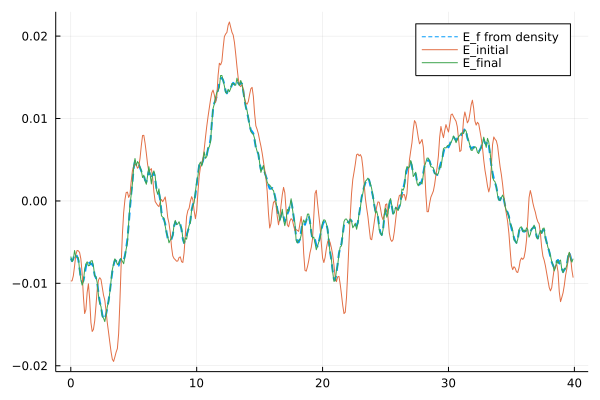

In [60]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)
j = M_g


#p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, par_grid)
get_ϕ!(ϕ_f, ρ_f .- 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plt = plot(x,E_f,label="E_f from density", ls=:dash, lw=2)
    plt = plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final")
    if save_plots
        png("Images/" * run_name * "_Efield")
    end
end
plt

In [61]:
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages(v,par_grid,par_evolv, par_f);

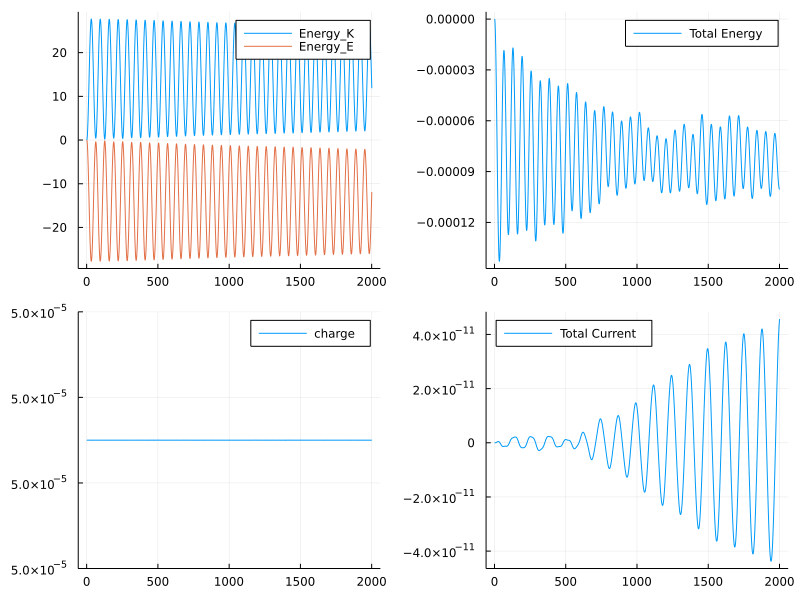

In [67]:
if plots 
    factor = 200
    plt = plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N, label="charge")
    plot!(subplot=4, S_T, label="Total Current", legend=:topleft)
    if save_plots
        png("Images/"  * run_name * "_total_run")
    end
end
plt

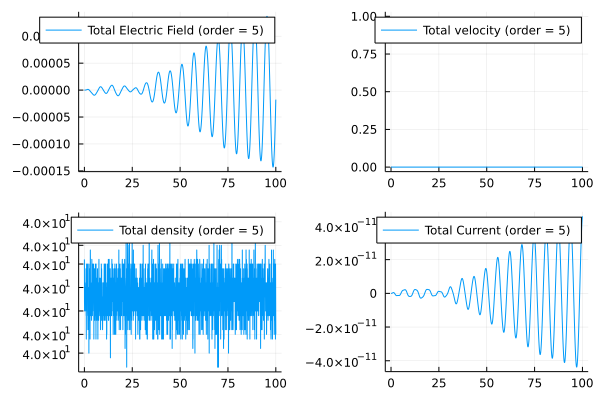

In [63]:
if plots || !remote_server
    plt = plot(layout=(2,2)) #, title="order = $(order)")
    plot!(subplot=1,t_series,EField_T,label="Total Electric Field (order = $(order))")
    plot!(subplot=2,t_series,p_T./N, label="Total velocity (order = $(order))")
    plot!(subplot=3,t_series,Q_T,label = "Total density (order = $(order))")
    plot!(subplot=4,t_series,S_T,label = "Total Current (order = $(order))")
    if save_plots
        png("Images/"  * run_name * "_totals")
    end
end
plt

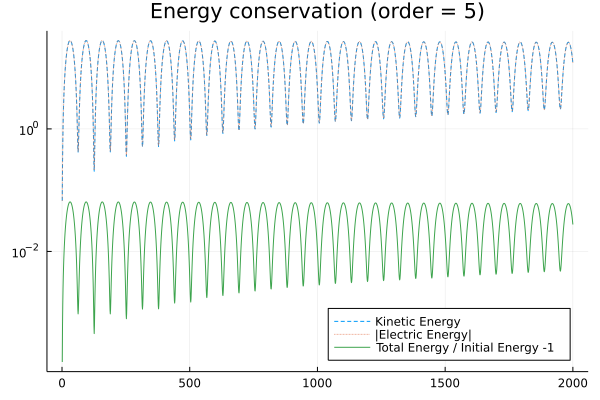

In [64]:
if plots || !remote_server
    plt = plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
    #, legend = :outertopright
    , legend = :bottomright, ls=:dash)
    plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
    plot!(abs.(2*Energy_K[2:end]  + Energy_E[2:end] .- (2*Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
    , yscale=:log10
    #, xscale=:log10
    , label = "Total Energy / Initial Energy -1 ")
    if save_plots
        png("Images/" * run_name * "energy_conservation")
    end
end
plt

In [71]:
@. model_tl001(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
p_tl001 = [1.; 6.; 2; 0; 0.1; 0; 1.; 0; 0]
fit_tl001 = curve_fit(model_tl001, t_series[1:end], T[1:end], p_tl001)
@. model_tl001_s(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
p_tl001_s = [0.001; 6; 2; 0; 0.0]
fit_tl001_s = curve_fit(model_tl001_s, t_series[1:end], T[1:end], p_tl001_s)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.0010398201586747956, -3.455723431274127e-5, 1.9968685666271373, -0.03486717318185687, 0.0014910322908374882], [5.526076914286627e-7, 4.383319950481638e-7, 3.2591005068500524e-7, 2.163873738215364e-7, 1.1076456015455052e-7, 9.987996936250063e-9, -8.505881845524352e-8, -1.7356327162770455e-7, -2.5479086193940133e-7, -3.280916044058786e-7  …  4.0177208422936643e-7, 4.4948493500363354e-7, 4.923824398002548e-7, 5.300064984407795e-7, 5.619490578406133e-7, 5.878564578697121e-7, 6.074332619407721e-7, 6.204455324620561e-7, 6.267235161993082e-7, 6.261637098626052e-7], [0.9999999999999915 0.9993922016969184 … -1.2046689507526446e-6 0.0; 0.9999999999999915 0.9978153941970523 … 2.243652748418575e-6 1.7240870201530973e-6; … ; 0.9999999999999915 0.05253242192159419 … -2.9717194420601106e-5 0.0001814467636543901; 0.9999999999999915 0.1379774236942504 … -2.938605322111336e-5 0.000476811845181979], true, Float64[]

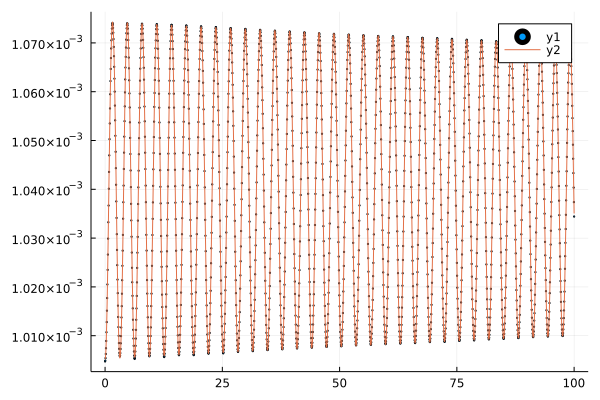

In [76]:
N_i =1
N_f = M_g
plt = Plots.scatter(t_series[N_i:N_f], T[N_i:N_f], ms = 1)
plot!(t_series[N_i:N_f], model_tl001_s(t_series[N_i:N_f],fit_tl001_s.param))
if save_plots
    png("Images/" * run_name * "temperature_fit")
end
plt

In [78]:
fit_tl001_s.param

5-element Vector{Float64}:
  0.0010398201586747956
 -3.455723431274127e-5
  1.9968685666271373
 -0.03486717318185687
  0.0014910322908374882

In [79]:
@. model_e1(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
pe1 = [1.0; 1; 2; 2; 0.002]
pe2 = [1.0; 1; 1; 0; 0.002; 0.5]

fit_energy_1 = curve_fit(model_e1, t_series, Energy_E, pe1);
fit_energy_2 = curve_fit(model_e2, t_series, Energy_E, pe2);
fit_energy_1.param
fit_energy_2.param

6-element Vector{Float64}:
 13.607599620335252
 27.643463391789627
  0.9984341373523262
 -0.01772744539542236
  0.0015074167481264826
  0.4911103587817054

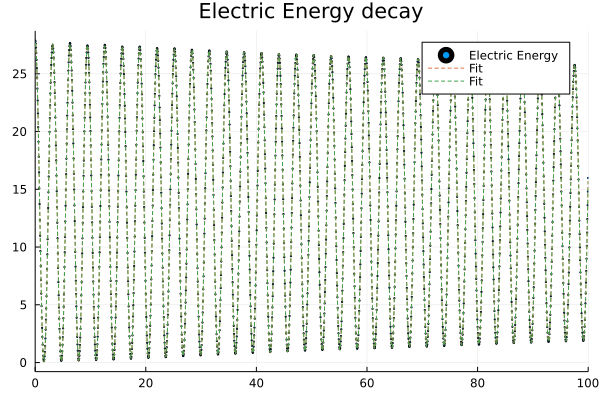

In [80]:
save_plots = true
if plots || !remote_server 
    plt = Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy decay"
    , label= "Electric Energy"
    #, yscale=:log10
    )

    plot!(t_series,model_e1(t_series,fit_energy_1.param), ls=:dash
    , markersize = 0.2
    #, xlims=(00,100)
    , label="Fit"
    )
    plot!(t_series,model_e2(t_series,fit_energy_2.param), ls=:dash
    , markersize = 0.2
    , xlims=(0,100)
    , label="Fit"
    )
    if save_plots
        png("Images/" * run_name * "_energy_fit")
    end
end
plt